In [ ]:
! pip install --upgrade emcee corner pytorch-lightning tqdm nflows getdist astropy --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astrostat 2.0.24 requires astropy==5.2.1, but you have astropy 6.0.1 which is incompatible.
astrostat 2.0.24 requires corner==2.2.1, but you have corner 2.2.2 which is incompatible.
astrostat 2.0.24 requires emcee==3.1.4, but you have emcee 3.1.6 which is incompatible.
astrostat 2.0.24 requires tqdm==4.65.0, but you have tqdm 4.66.4 which is incompatible.


In [ ]:
! pip install torch --quiet

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import emcee
from scipy.stats import poisson
from scipy.stats import chi2
from scipy.optimize import basinhopping
from tqdm import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import corner
from scipy.stats import norm
from getdist import plots, MCSamples
from scipy.integrate import quad

In [3]:
import multiprocessing
from multiprocessing import Pool

In [4]:
%matplotlib inline

In [5]:
torch.__version__

'2.3.0'

## Simulators

Simulators are computer programs that generate synthetic data from a model. They take as input a set of parameters $\theta$, sample a series of internal states or latent variables, $z_i \sim p(z_i | z_{<i}, \theta)$, and then generate a data vector $x \sim p(x | z, \theta)$.

In astronomy, some examples of simulators are:
- N-body simulations: simulate the evolution of a system of particles under the influence of gravity.
- Galaxy formation simulations: simulate the formation and evolution of galaxies.
- Stellar population synthesis: simulate the spectral energy distribution of a stellar population.

The latent variables $z$ sometimes correspond to physical quantities that are not directly observable (e.g. position of a particle in an N-body simulation) and sometimes can not have a direct physical interpretation (e.g. some internal state).


<center><img src="./assets/lfi_sim.png" width="800"></center>

The question is: 

***How can we use simulations to perform inference?***

## Simulation-based inference: The basic idea
Instead of trying to analytically evaluate the likelihood, we can build a forward model of the data &rarr; the stochastic simulator becomes the physical model.

The outputs of the simulator are this way samples of the observational data that we would expect to observe given the parameters $\theta$. So, if we simulate enough examples, we can measure the *frequency* of examples that are similar to the observed data, which is the same as sampling from the likelihood function!

This way, we can bypass the need to evaluate the likelihood function analytically, fully exploit the information content of the data, incorporate complex physical models, and systematic effects, and combine multiple probes by joint simulations.

<center>
<img src="./assets/meme_problem_solved.webp" width="400" />
</center>

***So why hasn't this been mainstream until now?***

### The challenge of simulation-based inference
The probability of a simulation run depends jointly on the observation and the *stochastic latent variables* $z$ of the simulator: $p(x,z | \theta)$. 

However, we only observe the data $x$, so the likelihood we need should be marginalized over the latent variables: $$p(x | \theta) = \int p(x,z | \theta) dz = \int p(x | z, \theta) p(z | \theta) dz$$

This is an integral over all possible trajectories through the latent space (i.e. all possible execution traces of the simulator). For realistic simulators, with large latent spaces, it is not feasible to evaluate this integral explicitly.

⮕ the marginal likelihood is intractable!

<center>
<img src="./assets/sbi.png" width="800" />
</center>

So, how do we deal with this?

A variety of algorithms:
<center><img src="./assets/sbibm_comparison.png" width="1000" /></center>

# **Example**: Supernova Lumonisity Distance

We'll consider a simplified model for the luminosity distance to supernovae, which depends on the cosmological parameters $\Omega_m$ (matter density parameter) and $H_0$ (Hubble constant).

The luminosity distance $d_L$ for a flat universe ($\Omega_k = 0$) can be approximated using the cosmological parameters. The apparent magnitude $m$ of a supernova is related to its luminosity distance.



For simplicity, we'll assume the following:
1. We have a set of supernovae with observed apparent magnitudes $m_{\text{obs}}$ and redshifts $z$.

2. The theoretical apparent magnitude $m_{\text{th}}$ is given by the distance modulus $\mu$
$$\mu = 5 \log_{10}(d_L) + 25, \tag{1}$$ 
where $d_L$ is the luminosity distance.

3. The luminosity distance $d_L$ depends on the cosmological parameters $\Omega_m$ and $H_0$.

Given the redshift $z$, the luminosity distance $d_L$ can be approximated by:
$$d_L = \frac{c(1+z)}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_m(1+z')^3 + (1-\Omega_m)}}, \tag{2}$$
where $c$ is the speed of light.

The problem that we will be solving is to <span style="color:red">*infer the cosmological parameters $\Omega_m$ and $H_0$ given the observed apparent magnitudes $m_{\text{obs}}$ and redshifts $z$ of the supernovae.*</span>
​	

## Standard Bayesian Inference
Let's first try to solve this problem using standard Bayesian inference. We'll assume that the observed apparent magnitudes $m_{\text{obs}}$ have Gaussian errors, and therefore, we can write down the likelihood function as a Gaussian over the observed data given the parameters $\Omega_m$ and $H_0$:
$$\mathcal{L}(\Omega_m, H_0) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp\left(-\frac{(m_{\text{obs},i} - m_{\text{th},i})^2}{2\sigma_i^2}\right), \tag{3}$$
where $N$ is the number of supernovae, $m_{\text{obs},i}$ is the observed apparent magnitude of supernova $i$, $m_{\text{th},i}$ is the theoretical apparent magnitude of supernova $i$, and $\sigma_i$ is the error in the observed apparent magnitude of supernova $i$.

First, we need to make up some mock observed data. We'll assume that the redshifts $z$ of the supernovae are known and generate the observed apparent magnitudes $m_{\text{obs}}$ using the theoretical apparent magnitudes $m_{\text{th}}$ and adding Gaussian noise:
$$ z \xrightarrow{(2)} d_L \xrightarrow{(1)} m_{\text{th}} \xrightarrow{} m_{\text{obs}} = m_{\text{th}} + \mathcal{N}(0, \sigma^2).$$

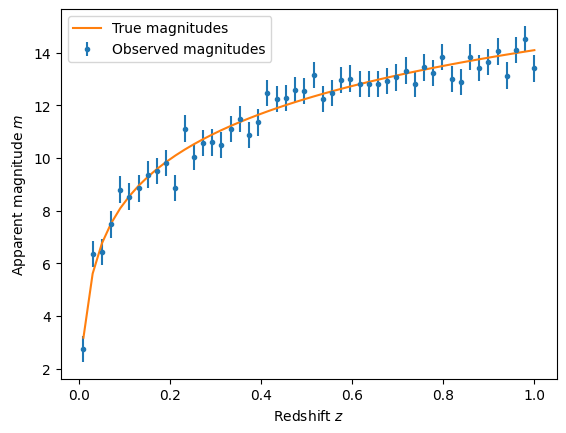

In [7]:
# Constants
c = 299792.458  # Speed of light in km/s

# True cosmological parameters
true_Omega_m = 0.3
true_H0 = 70.0  # Hubble constant in km/s/Mpc

# Redshifts of the supernovae
z = np.linspace(0.01, 1.0, 50)

# Noise level in the observed magnitudes
sigma = 0.5

# Luminosity distance function
def luminosity_distance(z, Omega_m, H0):
    """ Calculate the luminosity distance for a given redshift, Omega_m and H0 """
    integrand = lambda z_prime: 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + (1 - Omega_m))
    d_L = np.array([quad(integrand, 0, z_i)[0] for z_i in z])
    return (c * (1 + z) * d_L) / H0

# Generate synthetic data
d_L_true = luminosity_distance(z, true_Omega_m, true_H0)
m_true = 5 * np.log10(d_L_true / 10)
m_obs = m_true + np.random.normal(0, sigma, len(m_true))  # Adding Gaussian noise

# Plot synthetic data
plt.errorbar(z, m_obs, yerr=0.5, fmt='.', label='Observed magnitudes')
plt.plot(z, m_true, label='True magnitudes')
plt.xlabel('Redshift $z$')
plt.ylabel('Apparent magnitude $m$')
plt.legend()
plt.show()


We will consider a uniform prior for $ 0 < \Omega_m < 1$ and $50 < H_0 < 100$, the likelihood function in Eq. $(3)$, and the posterior from the Bayes theorem.

In [9]:
# Log-prior function
def log_prior(params):
    Omega_m, H0 = params
    if 0 < Omega_m < 1 and 50 < H0 < 100:
        return 0
    else:
        return -np.inf
    
# Define the log-likelihood function
def log_like(params, z, m_obs):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    sigma_m = 0.5  # Assumed standard deviation of magnitudes
    return -0.5 * np.sum(((m_obs - m_th) / sigma_m)**2)    

# Log-posterior function
def log_post(params, z, m_obs):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_like(params, z, m_obs)

Now, we just need to sample from the posterior using MCMC to get the posterior distribution of the parameters $\Omega_m$ and $H_0$.

In [ ]:
# Sampling with `emcee` 
ndim, nwalkers = 2, 32
ncpus = multiprocessing.cpu_count()

# Initialize walkers around a random position withing the prior volume
pos = np.random.uniform([0, 50], [1, 100], (nwalkers, ndim))

with Pool(ncpus) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(z, m_obs), pool=pool)
    sampler.run_mcmc(pos, 5000, progress=True)

Removed no burn in


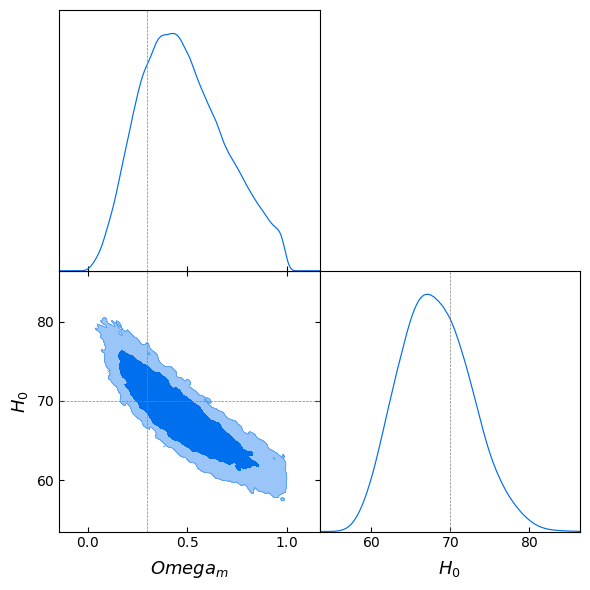

In [12]:
# Get samples and convert to GetDist MCSamples
flat_samples = sampler.get_chain(discard=1000, flat=True)

# GetDist plotting
samples = MCSamples(samples=flat_samples, names=['Omega_m', 'H0'], labels=['Omega_m', 'H_0'])
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(samples, filled=True, markers={'Omega_m': true_Omega_m, 'H0': true_H0})
plt.show()

# Simulation-based Inference

Now, let's try to solve the same problem using different simulation-based inference methods. To do this, we'll first need to construct a simulator for the luminosity distance to supernovae.

In [ ]:
# noise level
sigma = 0.5

# Forward model to simulate observed magnitudes
def luminosity_distance_simulator(params, z):
    Omega_m, H0 = params
    d_L = luminosity_distance(z, Omega_m, H0)
    m_th = 5 * np.log10(d_L / 10)
    m_sim = m_th + np.random.normal(0, sigma, len(m_th))
    return m_sim

This very simple simulator uses the theoretical model for the luminosity distance given by Eq. $(2)$ and $(1)$ to generate the theoretical apparent magnitudes $m_{\text{th}}$ for a given set of cosmological parameters $\Omega_m$ and $H_0$, and adds Gaussian noise to generate the observed apparent magnitudes $m_{\text{obs}}$.

## Traditional SBI - Approximate Bayesian Computation (ABC)

The first simulation-based inference method we'll use is ABC. ABC was one of the first simulation-based inference methods developed and is based on the idea of approximating the posterior distribution by sampling from the prior distribution and accepting samples that are "close enough" to the observed data.

General procedure:
1. Sample parameters from the prior distribution $\theta \sim p(\theta)$.
2. Forward simulate these parameters to generate synthetic observations $x \sim p(x | \theta)$.
3. Compare the synthetic observations to the real observed data $x_{\text{obs}}$ using a distance metric $d(x, x_{\text{obs}})$.
4. If the synthetic observations are "close enough" to the real observed data, i.e., $d(x, x_{\text{obs}}) < \epsilon$ for some threshold $\epsilon$, accept the parameters $\theta$ as samples from the posterior $p(\theta | x_{\text{obs}})$.

ABC does not require the likelihood function to be known, instead the likelihood is approximated by the probability that the condition $d(x, x_{\text{obs}}) < \epsilon$ is satisfied.

As the threshold $\epsilon \to 0$, the accepted samples converge to the true posterior. For $\epsilon > 0$, the inferred posterior will be broader than the true posterior, therefore the inference will be conservative.

<center><img src="./assets/abc.png" width="800" /></center>

Let's now try to apply ABC to our problem of inferring the cosmological parameters $\Omega_m$ and $H_0$ from supernova data. As a distance metric, we'll use the mean squared error (MSE) between the observed apparent magnitudes $m_{\text{obs}}$ and the synthetic apparent magnitudes $m_{\text{th}}$.

In [ ]:
# Distance metric: Mean Squared Error
def mse(x, x_sim):
    return np.sum((x - x_sim) ** 2) / len(x)

# ABC Algorithm
def abc(y, x, eps_thresh=0.5, num_samples=1000):
    """ Approximate Bayesian Computation (ABC) algorithm """
    accepted_samples = []
    trials = 0
    progress_bar = tqdm(total=num_samples, desc=f"Accepted Samples (eps={eps_thresh})")

    while len(accepted_samples) < num_samples:
        params = np.random.uniform(low=[0, 50], high=[1, 100])  # θ ~ p(θ) (Step 1)
        x_sim = luminosity_distance_simulator(params, y)  # x ~ p(x|θ) (Step 2)
        eps = mse(x, x_sim)  # Distance metric; d(x, x_sim) (Step 3)
        trials += 1

        # If accepted, add to samples (Step 4)
        if eps < eps_thresh:
            accepted_samples.append(params) 
            acceptance_ratio = len(accepted_samples) / trials 
            progress_bar.update(1)
            progress_bar.set_postfix(acceptance_ratio=f"{acceptance_ratio:.3f}")

    progress_bar.close()
    
    return np.array(accepted_samples)

We will run the ABC algorithm for two different values of $\epsilon$: $0.4$ and $0.6$.

In [ ]:
# Run ABC
eps_thresh = [0.4, 0.6]

# Run ABC for each epsilon threshold
results = {}
for eps in eps_thresh:
    results[eps] = abc(z, m_obs, eps_thresh=eps, num_samples=3000)

Accepted Samples (eps=0.6): 100%|██████████| 3000/3000 [00:09<00:00, 319.43it/s, acceptance_ratio=0.425]


Removed no burn in
Removed no burn in


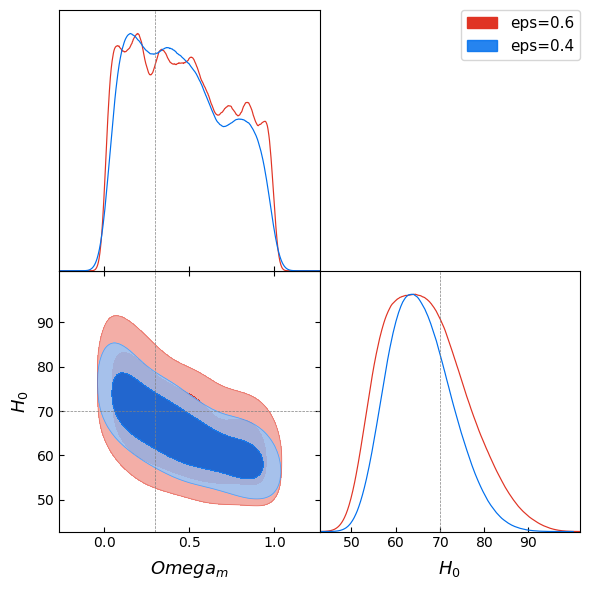

In [ ]:
# GetDist plotting
samples1 = MCSamples(samples=results[0.6], names=['Omega_m', 'H0'], labels=['Omega_m', 'H_0'])
samples2 = MCSamples(samples=results[0.4], names=['Omega_m', 'H0'], labels=['Omega_m', 'H_0'])

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples1, samples2], filled=True, markers={'Omega_m': true_Omega_m, 'H0': true_H0}, legend_labels=[f"eps={eps_thresh[1]}", f"eps={eps_thresh[0]}"])
plt.show()

We see that first of all, the posteriors that we get from ABC are reasonably close to the "true" posterior that we got from standard Bayesian inference. They are more-or-less centered around the true values of the parameters, and they follow a similar :banana: shape. However, as expected, the posteriors from ABC are broader than the true posterior, because of the relatively large values of $\epsilon$ that we used, and indeed, the bigger the $\epsilon$, the broader the posterior.

**Drawbacks of ABC:**
- We need to choose a distance metric that is appropriate for the problem.
- We have an extra hyperparameter to tune: the threshold $\epsilon$.
- Small values of $\epsilon$ require unfeasibly many simulations, while large values lead reduced accuracy.
- The sample efficiency of ABC scales poorly to high-dimensional data $x$ and high-dimensional parameters $\theta$.
- Inference for new data or different choice of prior requires re-running the entire algorithm.

# Sample generation & normalization

In [ ]:
np.random.seed(1234) # use random seed for reproducibility

# Generate training data
n_train = 50_000
param_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_train, 2)) # Parameter proposal
x_samples = np.array([luminosity_distance_simulator(theta, z) for theta in tqdm(param_samples)])

# Convert to tensors
param_samples = torch.tensor(param_samples, dtype=torch.float32)
x_samples = torch.tensor(x_samples, dtype=torch.float32)

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [01:00<00:00, 823.90it/s]


In [ ]:
def normalize(data):
    """ Normalizes the data to have mean 0 and standard deviation 1. """
    mean = data.mean(dim=0)
    std = data.std(dim=0)
    return (data - mean) / std, mean, std

In [ ]:
# Normalize the training data
x_norm, x_mean, x_std = normalize(x_samples)
param_norm, param_mean, param_std = normalize(param_samples)

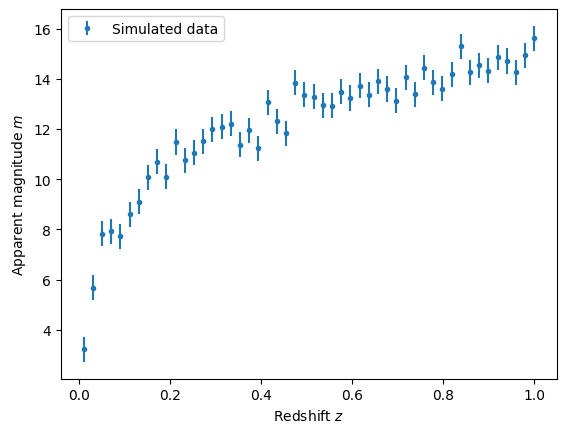

In [ ]:
# plot the training data
plt.errorbar(z, x_samples[49999], yerr=sigma, fmt='.', label='Simulated data')
plt.xlabel('Redshift $z$')
plt.ylabel('Apparent magnitude $m$')
plt.legend()
plt.show()

# NPE

In [ ]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [ ]:
class NeuralPosteriorEstimator(pl.LightningModule):
    """
    Neural Posterior Estimator using a normalizing flow as the posterior density estimator.

    Parameters:
        featurizer (nn.Module): Neural network for feature extraction.
        d_context (int): Dimension of the context vector.
    """
    
    def __init__(self, featurizer, d_context=16):
        super().__init__()
        self.featurizer = featurizer # Featurizer network for context extraction
        self.flow = self._build_flow(d_in=2, d_hidden=32, d_context=d_context, n_layers=4) # Normalizing flow
    
    def _build_flow(self, d_in, d_hidden, d_context, n_layers):
        """ Instantiate a normalizing flow with Masked Autoregressive Transformations. """
        base_dist = StandardNormal(shape=[d_in]) # base distribution of NF = standard normal 
        transforms = [] # List to hold the series of transformations
        
        for _ in range(n_layers):
            # Reverse permutation to shuffle the features
            transforms.append(ReversePermutation(features=d_in))
            
            # Masked Autoregressive Transform for flexible and expressive transformations
            transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
            
        # Combine all transformations into a composite transform
        transform = CompositeTransform(transforms)
        
        return Flow(transform, base_dist)    

    def forward(self, x):
        return self.featurizer(x) # Extract features using the featurizer
    
    def loss(self, x, params):
        context = self(x)  # Extract context from x using the featurizer
        return -self.flow.log_prob(inputs=params, context=context) # Compute negative log probability

    def training_step(self, batch):
        x, params = batch 
        loss = self.loss(x, params).mean()  # Compute mean loss
        self.log("train_loss", loss) # Log the training loss
        return loss

    def validation_step(self, batch):
        x, params = batch
        loss = self.loss(x, params).mean() # Compute mean validation loss
        self.log("val_loss", loss) # Log the validation loss
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4) 

In [ ]:
# Instantiate the featurizer and NeuralPosteriorEstimator
featurizer = build_mlp(input_dim=50, hidden_dim=128, output_dim=16, num_layers=4)
npe = NeuralPosteriorEstimator(featurizer=featurizer, d_context=16)

In [ ]:
# Evaluate initial loss on a small sample
initial_loss = npe.loss(x_norm[:64], param_norm[:64]).mean().item()
print(f"Initial loss: {initial_loss}")

Initial loss: 5.094052314758301


In [ ]:
# Create dataset
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_norm))

dataset = TensorDataset(x_norm, param_norm)
dataset_train, dataset_val = random_split(dataset, [len(x_samples) - n_samples_val, n_samples_val])

train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

In [ ]:
# Train the model
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=npe, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/tersenov/anaconda3/envs/astrostat24/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tersenov/anaconda3/envs/astrostat24/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | featurizer | Sequential | 74.6 K | train
1 | flow       | Flow       | 24.3 K | train
-----------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
# Test the trained model
param_test = np.array([0.3, 70.0])
x_test = luminosity_distance_simulator(param_test, z)

x_test_norm = (torch.Tensor(x_test) - x_mean) / x_std
context = npe.featurizer(x_test_norm).unsqueeze(0)

In [ ]:
# Sample from the trained normalizing flow
test_samples = npe.flow.sample(num_samples=10000, context=context) * param_std + param_mean
test_samples = test_samples.detach().numpy().squeeze(0)

Removed no burn in


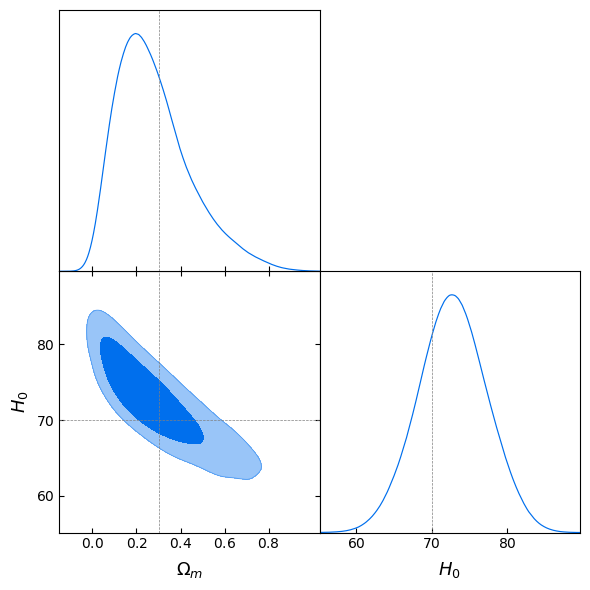

In [ ]:
# Create a MCSamples instance
samples = MCSamples(samples=test_samples, labels=['\Omega_m', 'H_0'], names=['Omega_m', 'H_0'])

true_Omega_m = 0.3
true_H0 = 70

# Create a GetDist plot
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples], filled=True, markers={'Omega_m': true_Omega_m, 'H_0': true_H0})
plt.show()

## Coverage Test

In [ ]:
# Generate test samples
n_test = 1000
param_test_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_test, 2))
x_test_samples = np.array([luminosity_distance_simulator(params, z) for params in tqdm(param_test_samples)])

# Normalize test data
x_test_samples_norm = (torch.tensor(x_test_samples, dtype=torch.float32) - x_mean) / x_std

# Featurize test data
context = npe.featurizer(x_test_samples_norm)

# Sample from the posterior for test data
samples_test = npe.flow.sample(num_samples=1000, context=context) * param_std + param_mean
samples_test = samples_test.detach().numpy()

100%|██████████| 1000/1000 [00:01<00:00, 825.86it/s]


In [ ]:
def HPD(samples, credible_mass=0.95):
    """
    Compute the highest posterior density (HPD) interval of the given samples for a given credible mass.
    
    Args:
        samples (np.ndarray): Array of samples.
        credible_mass (float): The desired credible mass for the HPD interval.
        
    Returns:
        (float, float): The lower and upper bounds of the HPD interval.
    """
    sorted_samples = np.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * len(sorted_samples)))
    n_intervals = len(sorted_samples) - interval_idx_inc
    interval_width = sorted_samples[interval_idx_inc:] - sorted_samples[:n_intervals]
    min_idx = np.argmin(interval_width)
    hdi_min = sorted_samples[min_idx]
    hdi_max = sorted_samples[min_idx + interval_idx_inc]
    return hdi_min, hdi_max

In [ ]:
# Compute empirical coverage
p_nominals = np.linspace(0.01, 0.99, 50)
contains_true = np.zeros((2, len(p_nominals)))

for i_param in range(2):
    for i, sample in enumerate(samples_test[:, :, i_param]):
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = HPD(sample, credible_mass=p_nominal)
            if hdi_min < param_test_samples[i, i_param] < hdi_max:
                contains_true[i_param, j] += 1

# Calculate the empirical coverage
empirical_coverage = contains_true / n_test

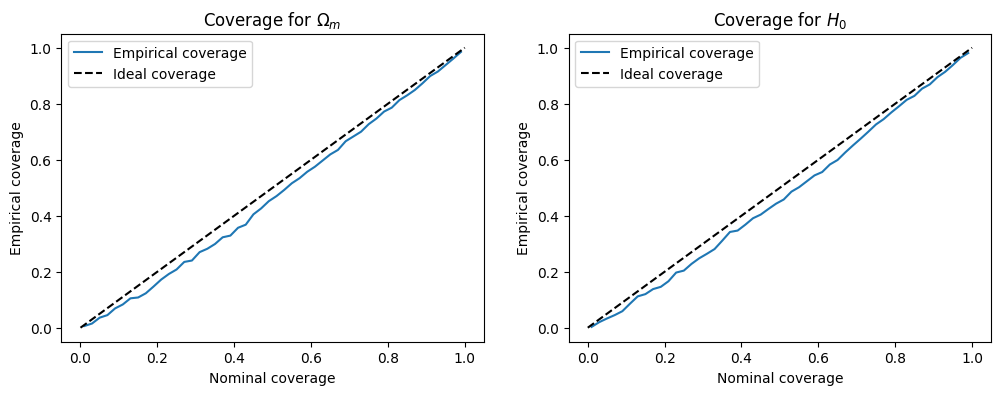

In [ ]:
# Plot the coverage
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

param_names = ["$\Omega_m$", "$H_0$"]
for i in range(2):
    ax[i].plot(p_nominals, empirical_coverage[i], label='Empirical coverage')
    ax[i].plot([0, 1], [0, 1], color="black", linestyle="--", label='Ideal coverage')
    ax[i].set_xlabel("Nominal coverage")
    ax[i].set_ylabel("Empirical coverage")
    ax[i].set_title(f"Coverage for {param_names[i]}")
    ax[i].legend()

plt.show()

# NRE

In [ ]:
def build_mlp(input_dim, hidden_dim, output_dim, num_layers, activation=nn.GELU()):
    """Builds a multi-layer perceptron (MLP) neural network."""
    layers = [nn.Linear(input_dim, hidden_dim), activation]  # First layer and activation
    
    for _ in range(num_layers):
        layers += [nn.Linear(hidden_dim, hidden_dim), activation] # Hidden layers and activations
        
    layers += [nn.Linear(hidden_dim, output_dim)] # Output layer
    
    return nn.Sequential(*layers)

In [ ]:
class NeuralRatioEstimator(pl.LightningModule):
    """
    Neural Ratio Estimator using a multi-layer perceptron (MLP).

    Parameters:
        x_dim (int): Dimension of the input data.
        param_dim (int): Dimension of the parameter space.
    """
    def __init__(self, x_dim, param_dim):
        super().__init__()
        # Build MLP model with input dimensions from data and parameters
        self.mlp = build_mlp(input_dim=x_dim + param_dim, hidden_dim=128, output_dim=1, num_layers=4)

    def forward(self, x):
        return self.mlp(x)
    
    def loss(self, x, params):
        # Repeat x in groups of 2 along batch axis
        x_repeated = x.repeat_interleave(2, dim=0)

        # Get a shuffled version of theta
        params_shuffled = params[torch.randperm(params.shape[0])]

        # Interleave theta and shuffled theta
        params_combined = torch.stack([params, params_shuffled], dim=1).reshape(-1, params.shape[1])

        # Create labels: 1 for original pairs (joint), 0 for shuffled pairs (marginals)
        labels = torch.ones(x_repeated.shape[0], device=x.device)
        labels[1::2] = 0.0

        # Compute logits from the MLP and apply sigmoid for probabilities
        logits = self(torch.cat([x_repeated, params_combined], dim=1))
        probs = torch.sigmoid(logits).squeeze()

        return nn.BCELoss(reduction='none')(probs, labels)  # Return binary cross-entropy loss


    def training_step(self, batch):
        x, params = batch
        loss = self.loss(x, params).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch):
        x, params = batch
        loss = self.loss(x, params).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [ ]:
# Initialize the model
model = NeuralRatioEstimator(x_dim=50, param_dim=2)

# Evaluate initial loss on a small sample
initial_loss = model.loss(x_norm[:64], param_norm[:64]).mean().item()
print(f"Initial loss: {initial_loss}")

Initial loss: 0.6931858062744141


In [ ]:
from torch.utils.data import DataLoader, random_split, TensorDataset

# Create dataset and dataloaders
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_samples))

dataset = TensorDataset(x_norm, param_norm)
dataset_train, dataset_val = random_split(dataset, [len(x_norm) - n_samples_val, n_samples_val])

train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

# Train the model
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/tersenov/anaconda3/envs/astrostat24/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tersenov/anaconda3/envs/astrostat24/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | mlp  | Sequential | 73.0 K | train
--------------------------------------------
73.0 K    Trainable params
0 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
def log_prior(params):
    """ Log-prior distribution for the parameters. """
    Omega_m, H0 = params
    if 0 < Omega_m < 1 and 50 < H0 < 100:
        return 0.0  # Uniform prior
    else:
        return -np.inf  # Log(0) for invalid values
    
def log_like(params, x):
    """ Log-likelihood ratio estimator using trained classifier logits. """
    x = torch.Tensor(x)
    params = torch.Tensor(params)

    # Normalize
    x = (x - x_mean) / x_std
    params = (params - param_mean) / param_std

    x = torch.atleast_1d(x)
    params = torch.atleast_1d(params)

    return model.mlp(torch.cat([x, params], dim=-1)).squeeze()

def log_post(params, x):
    """ Log-posterior distribution for the parameters given the observed data. """
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    else:
        #return torch.tensor().detach().numpy( lp + log_like(theta, x) )
        return (lp + log_like(params, x)).detach().numpy()

In [ ]:
# Generate synthetic test data
params_test = np.array([0.3, 70.0])
x_test = luminosity_distance_simulator(params_test, z)

In [ ]:
# Run MCMC sampling
ndim, nwalkers = 2, 32
ncpus = multiprocessing.cpu_count()

pos = params_test + 1e-3 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(x_test,))
sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:55<00:00, 89.30it/s]


State([[9.45093006e-01 5.71504184e+01]
 [7.21830389e-01 6.47511810e+01]
 [5.04442856e-01 6.20810755e+01]
 [2.07643945e-01 7.18051614e+01]
 [7.63294402e-01 6.00820709e+01]
 [6.93561882e-01 6.32770603e+01]
 [8.50115324e-01 5.91514884e+01]
 [4.08040560e-01 6.46144497e+01]
 [3.44041229e-01 6.59234542e+01]
 [1.87284636e-01 7.43231686e+01]
 [6.38095660e-01 6.18611587e+01]
 [3.65587602e-01 6.92351492e+01]
 [3.91821787e-01 6.86034498e+01]
 [7.52158715e-01 6.53186493e+01]
 [7.03908283e-01 6.38778664e+01]
 [6.84793703e-01 6.08872772e+01]
 [7.30175239e-02 7.42610558e+01]
 [1.39430414e-01 7.58072723e+01]
 [2.93999358e-01 6.75046813e+01]
 [5.03758035e-01 6.18929552e+01]
 [4.14409575e-01 6.69366468e+01]
 [6.91316249e-01 6.62721211e+01]
 [2.21900583e-01 7.49273469e+01]
 [3.81675747e-01 6.44225030e+01]
 [2.88704614e-01 7.18655291e+01]
 [3.66785212e-01 6.43648772e+01]
 [5.57866294e-01 6.52422330e+01]
 [9.97747545e-01 5.42726954e+01]
 [3.16863211e-01 7.19447148e+01]
 [4.61668404e-01 6.60855437e+01]
 [8.

Removed no burn in


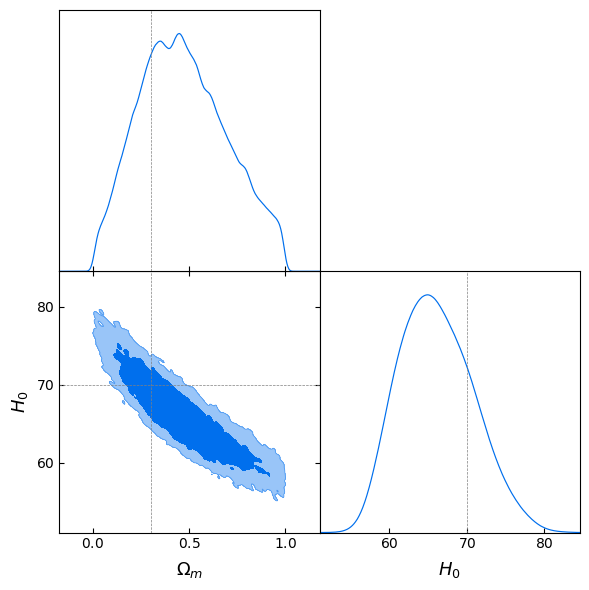

In [ ]:
# Get samples and convert to GetDist MCSamples
flat_samples = sampler.get_chain(discard=1000, flat=True)

# GetDist plotting
samples = MCSamples(samples=flat_samples, names=['\Omega_m', 'H_0'], labels=['\Omega_m', 'H_0'])
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(samples, filled=True, markers={'\Omega_m': true_Omega_m, 'H_0': true_H0})
plt.show()

### Coverage test

In [ ]:
# Define HPD interval function
def HPD(samples, credible_mass=0.95):
    """
    Compute the highest posterior density (HPD) interval of the given samples for a given credible mass.
    
    Args:
        samples (np.ndarray): Array of samples.
        credible_mass (float): The desired credible mass for the HPD interval.
        
    Returns:
        (float, float): The lower and upper bounds of the HPD interval.
    """
    sorted_samples = np.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * len(sorted_samples)))
    n_intervals = len(sorted_samples) - interval_idx_inc
    interval_width = sorted_samples[interval_idx_inc:] - sorted_samples[:n_intervals]
    min_idx = np.argmin(interval_width)
    hdi_min = sorted_samples[min_idx]
    hdi_max = sorted_samples[min_idx + interval_idx_inc]
    return hdi_min, hdi_max

In [ ]:
# Function to sample posterior using MCMC
def sample_posterior_mcmc(log_posterior, x, n_samples=1000, nwalkers=20, nsteps=1000):
    ndim = 2
    initial_pos = np.random.randn(nwalkers, ndim) * 1e-3 + np.array([0.3, 70.0])

    # MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x,))
    sampler.run_mcmc(initial_pos, nsteps, progress=True)

    # Get the samples
    samples = sampler.get_chain(discard=300, thin=15, flat=True)
    return samples

In [ ]:
# Generate test samples
n_test = 100
theta_test_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_test, 2))
x_test_samples = np.array([luminosity_distance_simulator(theta, z) for theta in tqdm(theta_test_samples)])

# Normalize test data
x_test_samples_norm = (torch.tensor(x_test_samples, dtype=torch.float32) - x_mean) / x_std

100%|██████████| 100/100 [00:00<00:00, 655.33it/s]


In [ ]:
# Compute empirical coverage
p_nominals = np.linspace(0.01, 0.99, 50)
contains_true = np.zeros((2, n_test, len(p_nominals)))

for i_param in range(2):
    for i, theta_test in enumerate(tqdm(theta_test_samples)):
        x_test = x_test_samples[i]
        posterior_samples = sample_posterior_mcmc(log_post, x_test, n_samples=1000)
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = HPD(posterior_samples[:, i_param], credible_mass=p_nominal)
            if hdi_min < theta_test[i_param] < hdi_max:
                contains_true[i_param, i, j] = 1

In [ ]:
# Calculate the empirical coverage
empirical_coverage = contains_true.mean(axis=1)

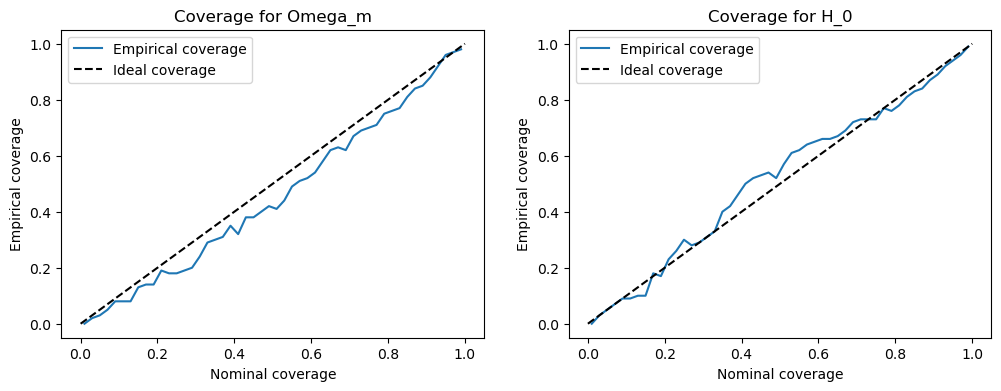

In [ ]:
# Plot the coverage
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

param_names = ["Omega_m", "H_0"]
for i in range(2):
    ax[i].plot(p_nominals, empirical_coverage[i], label='Empirical coverage')
    ax[i].plot([0, 1], [0, 1], color="black", linestyle="--", label='Ideal coverage')
    ax[i].set_xlabel("Nominal coverage")
    ax[i].set_ylabel("Empirical coverage")
    ax[i].set_title(f"Coverage for {param_names[i]}")
    ax[i].legend()

plt.show()

# NLE

In [ ]:
# Define the neural likelihood estimator
class NeuralLikelihoodEstimator(pl.LightningModule):
    """Simple neural likelihood estimator class using a normalizing flow as the likelihood density estimator."""
    def __init__(self, d_context=2):
        super().__init__()
        self.flow = self._build_flow(d_in=50, d_hidden=128, d_context=d_context, n_layers=4)

    def _build_flow(self, d_in, d_hidden, d_context, n_layers):
        """ Instantiate a normalizing flow with Masked Autoregressive Transformations. """
        base_dist = StandardNormal(shape=[d_in])
        transforms = []
        for _ in range(n_layers):
            transforms.append(ReversePermutation(features=d_in))
            transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, hidden_features=d_hidden, context_features=d_context))
        transform = CompositeTransform(transforms)
        flow = Flow(transform, base_dist)
        return flow
    
    def loss(self, params, x):
        return -self.flow.log_prob(inputs=x, context=params)

    def training_step(self, batch):
        params, x = batch
        loss = self.loss(params, x).mean()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch):
        params, x = batch
        loss = self.loss(params, x).mean()
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [ ]:
nle = NeuralLikelihoodEstimator()

In [ ]:
# Create data loaders
val_fraction = 0.1
batch_size = 128
n_samples_val = int(val_fraction * len(x_norm))

dataset = TensorDataset(param_norm, x_norm)
dataset_train, dataset_val = random_split(dataset, [len(x_norm) - n_samples_val, n_samples_val])

train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

In [ ]:
# Train the model
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model=nle, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/tersenov/anaconda3/envs/astrostat24/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tersenov/anaconda3/envs/astrostat24/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params | Mode 
--------------------------------------
0 | flow | Flow | 346 K  | train
--------------------------------------
346 K     Trainable params
0         Non-trainable pa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
# Define the prior distribution
def log_prior(params):
    Omega_m, H0 = params
    if 0 < Omega_m < 1 and 50 < H0 < 100:
        return 0.0  # Uniform prior
    else:
        return -np.inf  # Log(0) for invalid values

# Define the log-posterior function
def log_posterior(params, x):    
    params = torch.tensor(params, dtype=torch.float32)
    x = torch.tensor(x, dtype=torch.float32)
    
    lp = log_prior(params)
    
    # Normalize
    x = (x - x_mean) / x_std
    context = (params - param_mean) / param_std
    context = context.unsqueeze(0)
    
    # Compute Likelihood
    with torch.no_grad():
        log_likelihood = nle.flow.log_prob(x.unsqueeze(0), context).item()

    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_likelihood

In [ ]:
params_test = np.array([0.3, 70.0])
x_test = luminosity_distance_simulator(params_test, z)

In [ ]:
# Set up the MCMC sampler
ndim = 2
nwalkers = 20
nsteps = 3000

# Initial positions of the walkers
initial_pos = [params_test + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# Observed data
x_test = luminosity_distance_simulator(params_test, z)

# MCMC sampler
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_test,), pool=pool)
    sampler.run_mcmc(initial_pos, nsteps, progress=True)

100%|██████████| 3000/3000 [00:31<00:00, 94.97it/s] 


Removed no burn in


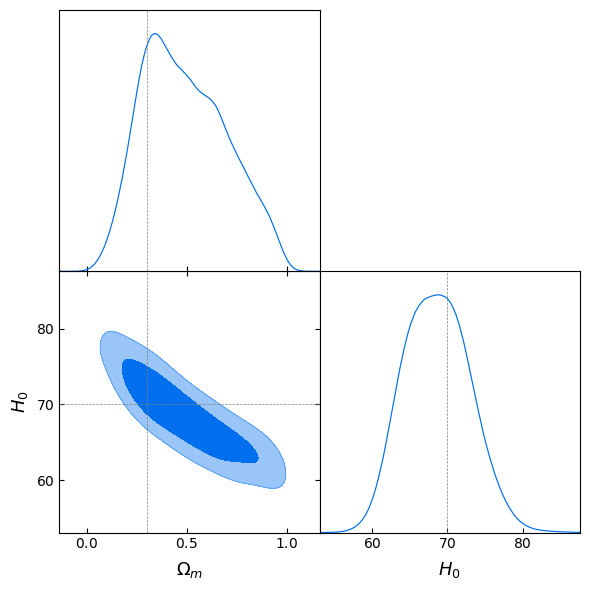

In [ ]:
# Get the samples
samples = sampler.get_chain(discard=500, thin=15, flat=True)

# Create a MCSamples instance
samples_mcs = MCSamples(samples=samples, labels=['\Omega_m', 'H_0'], names=['\Omega_m', 'H_0'])

# Create a GetDist plot
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples_mcs], filled=True, markers={'\Omega_m': 0.3, 'H_0': 70})

plt.show()

## Coverage test

In [ ]:
# Generate test samples
n_test = 200
param_test_samples = np.random.uniform(low=[0, 50], high=[1, 100], size=(n_test, 2))
x_test_samples = np.array([luminosity_distance_simulator(params_test, z) for params_test in tqdm(param_test_samples)])

# Normalize test data
x_test_samples_norm = (torch.tensor(x_test_samples, dtype=torch.float32) - x_mean) / x_std

100%|██████████| 200/200 [00:00<00:00, 821.26it/s]


In [ ]:
# Define HPD interval function
def HPD(samples, credible_mass=0.95):
    """
    Compute the highest posterior density (HPD) interval of the given samples for a given credible mass.
    
    Args:
        samples (np.ndarray): Array of samples.
        credible_mass (float): The desired credible mass for the HPD interval.
        
    Returns:
        (float, float): The lower and upper bounds of the HPD interval.
    """
    sorted_samples = np.sort(samples)
    interval_idx_inc = int(np.floor(credible_mass * len(sorted_samples)))
    n_intervals = len(sorted_samples) - interval_idx_inc
    interval_width = sorted_samples[interval_idx_inc:] - sorted_samples[:n_intervals]
    min_idx = np.argmin(interval_width)
    hdi_min = sorted_samples[min_idx]
    hdi_max = sorted_samples[min_idx + interval_idx_inc]
    return hdi_min, hdi_max

In [ ]:
# Function to sample posterior using MCMC
def sample_posterior_mcmc(log_posterior, x, n_samples=1000, nwalkers=10, nsteps=1000):
    ndim = 2
    params_test = np.array([0.3, 70.0])
    initial_pos = [params_test + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

    # MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x,))
    sampler.run_mcmc(initial_pos, nsteps, progress=True)

    # Get the samples
    samples = sampler.get_chain(discard=500, thin=15, flat=True)
    return samples

In [ ]:
# Compute empirical coverage
p_nominals = np.linspace(0.01, 0.99, 50)
contains_true = np.zeros((2, n_test, len(p_nominals)))

In [ ]:
for i_param in range(2):
    for i, param_test in enumerate(tqdm(param_test_samples)):
        x_test = x_test_samples[i]
        posterior_samples = sample_posterior_mcmc(log_posterior, x_test, n_samples=1000)
        for j, p_nominal in enumerate(p_nominals):
            hdi_min, hdi_max = HPD(posterior_samples[:, i_param], credible_mass=p_nominal)
            if hdi_min < params_test[i_param] < hdi_max:
                contains_true[i_param, i, j] = 1

In [ ]:
# Calculate the empirical coverage
empirical_coverage = contains_true.mean(axis=1)

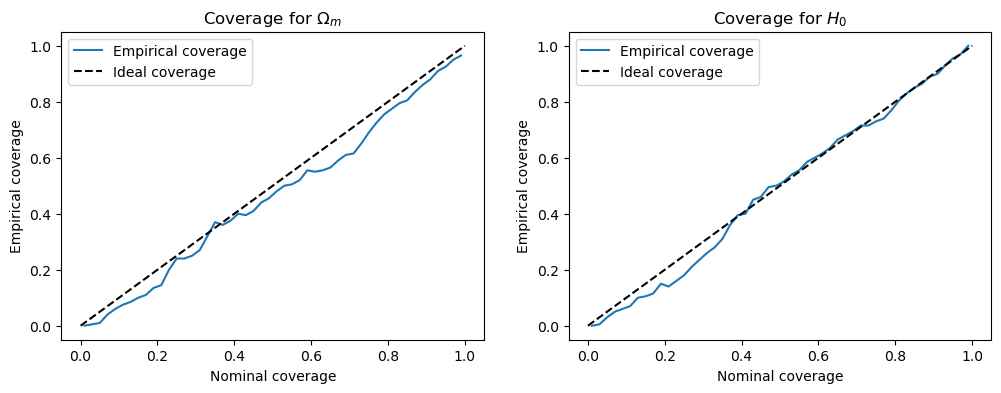

In [ ]:
# Plot the coverage
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

param_names = [r"$\Omega_m$", "$H_0$"]
for i in range(2):
    ax[i].plot(p_nominals, empirical_coverage[i], label='Empirical coverage')
    ax[i].plot([0, 1], [0, 1], color="black", linestyle="--", label='Ideal coverage')
    ax[i].set_xlabel("Nominal coverage")
    ax[i].set_ylabel("Empirical coverage")
    ax[i].set_title(f"Coverage for {param_names[i]}")
    ax[i].legend()

plt.show()

## Change the priors

In [ ]:
mu_prior = np.array([0.3, 70.0])
sigma_prior = np.array([0.1, 10.0])

def log_prior_gauss(params):
    Omega_m, H0 = params
    prior_log_prob = -0.5 * (((params - mu_prior) / sigma_prior) ** 2).sum()
    return prior_log_prob

def log_posterior_gauss(params, x_obs, nle):
    params = torch.tensor(params, dtype=torch.float32)
    context = (params - param_mean) / param_std
    context = context.unsqueeze(0)
    
    with torch.no_grad():
        log_likelihood = nle.flow.log_prob(x_obs.unsqueeze(0), context).item()
    
    lp = log_prior_gauss(params.numpy())
    
    return log_likelihood + lp

In [ ]:
# Set up the MCMC sampler
ndim = 2
nwalkers = 20
nsteps = 3000

# Initial positions of the walkers
initial_pos = [params_test + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

# Observed data
x_obs = (torch.tensor(luminosity_distance_simulator(params_test, z), dtype=torch.float32) - x_mean) / x_std

# MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_gauss, args=(x_obs, nle))

# Run MCMC
sampler.run_mcmc(initial_pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=500, thin=15, flat=True)

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:59<00:00, 50.54it/s]


Removed no burn in


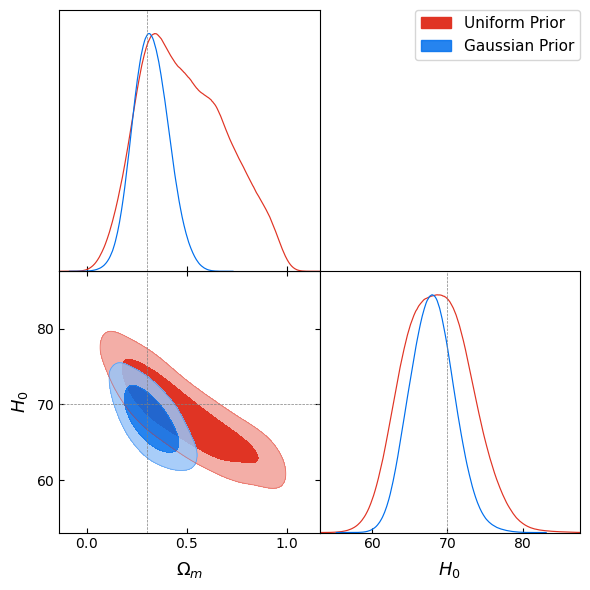

In [ ]:
# Create a MCSamples instance
samples_mcs_gauss = MCSamples(samples=samples, labels=['\Omega_m', 'H_0'], names=['\Omega_m', 'H_0'])

# Create a GetDist plot
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot([samples_mcs, samples_mcs_gauss], filled=True, markers={'\Omega_m': 0.3, 'H_0': 70}, legend_labels=['Uniform Prior', 'Gaussian Prior'])
plt.show()